## 데이터 불러오기

In [ ]:
Best params = {
    'iterations': 626,
    'depth': 8,
    'learning_rate': 0.18434234865711102,
    'l2_leaf_reg': 0.6087258503740413, 
    'bagging_temperature': 0.6133479845494182, 
    'border_count': 240, 
    'random_strength': 0.3486539015187813 }       

In [6]:
import pandas as pd

train = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/train.csv')
test = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/test.csv')

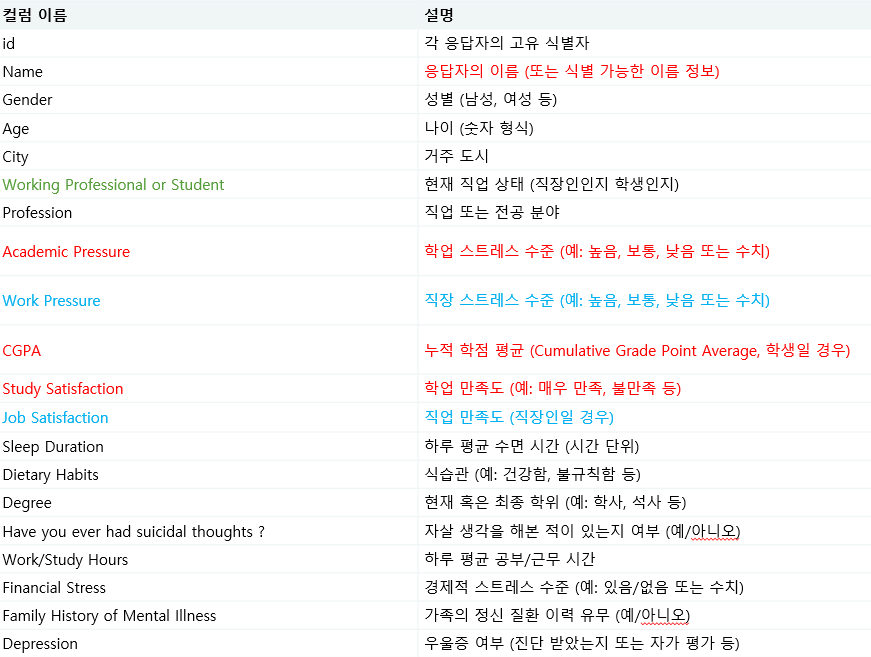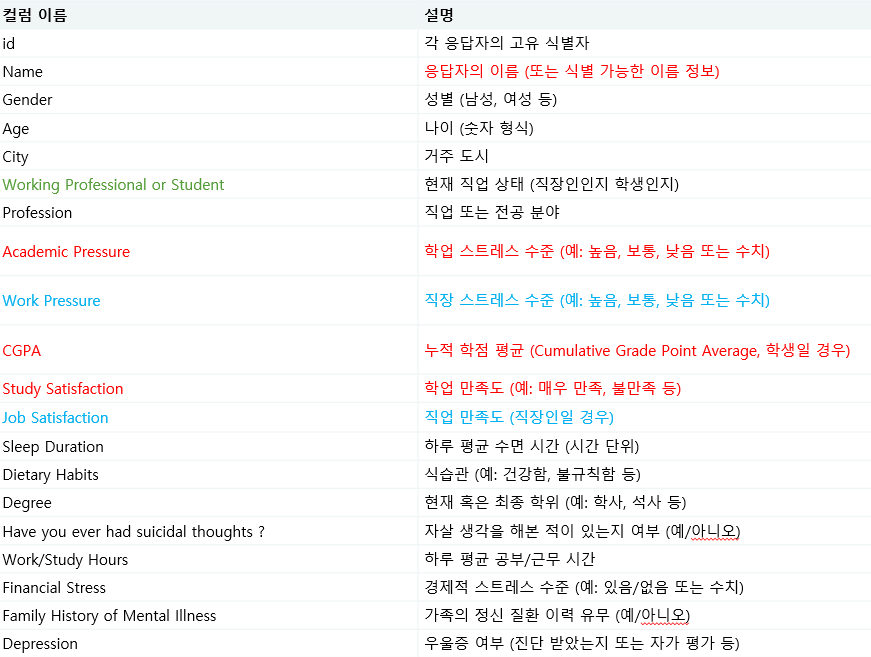

- 목표: Deppession (이진 분류)
- 데이터 특징: 범주형 + 수치형 + 민감 응답 혼합

## 환경 설정

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## 전처리

In [68]:
train = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/train.csv')
test = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/test.csv')

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

| 컬럼명                                     | 처리 방법 요약                          | 비고              |
| --------------------------------------- | --------------------------------- | --------------- |
| `id`                                    | 삭제                                | 식별자             |
| `Name`                                  | 삭제                                | 개인정보            |
| `Gender`                                | `0`, `1`로 매핑                      | 이진 인코딩          |
| `Age`                                   | 스케일링                              | 연속형             |
| `City`                                  | 상위 15개 유지 + 나머지 `Other`로 묶기       | 희소도 감소          |
| `Working Professional or Student`       | 그대로 사용                            | 이진 분류 가능        |
| `Profession`                            | `Missing` 값 대체 또는 별도 클래스 처리       | 결측 약 26%        |
| `Academic Pressure`                     | 결측률 80% → **살리되 Imputer 사용** + Missing 여부 컬럼 추가     | 중요한 변수, 주의      |
| `Work Pressure`                         | 결측률 20% → Imputer 사용 + Missing 여부 컬럼 추가            | 보존              |
| `CGPA`                                  | 결측률 80% → **삭제**                  | 상관관계 약함         |
| `Study Satisfaction`                    | 결측률 80% → **살리되 Imputer 사용** + Missing 여부 컬럼 추가     | 중요도 고려          |
| `Job Satisfaction`                      | 결측률 20% → Imputer 사용  + Missing 여부 컬럼 추가            | 보존              |
| `Sleep Duration`                        | 맵핑 후 float형으로 변환                  | 예: "7시간" → 7.0  |
| `Dietary Habits`                        | 상위 3개 유지, 나머지는 최빈값 또는 `Other`로 대체 | 이상값 많음          |
| `Degree`                                | 맵핑하여 정리 (예: 학사/석사/기타 등 그룹화)       | 범주 축소           |
| `Have you ever had suicidal thoughts ?` | `0`, `1`로 매핑                      | 이진 인코딩          |
| `Work/Study Hours`                      | 스케일링                              | 연속형             |
| `Financial Stress`                      | 스케일링                              | Likert 타입일 수 있음 |
| `Family History of Mental Illness`      | 그대로 사용                            | 예/아니요           |
| `Depression` *(Target)*                 | 그대로 사용 (`0`, `1`)                 | 타겟              |


### 0. 삭제

In [70]:
train.drop(columns=['id'], inplace=True)
train.drop(columns=['Name'], inplace=True)

### 1. 결측치 처리

In [71]:
missing_ratio = train.isnull().mean().sort_values(ascending=False) * 100

print(missing_ratio)

Academic Pressure                        80.172708
Study Satisfaction                       80.172708
CGPA                                     80.171997
Profession                               26.034115
Work Pressure                            19.842217
Job Satisfaction                         19.836532
Financial Stress                          0.002843
Dietary Habits                            0.002843
Degree                                    0.001421
Family History of Mental Illness          0.000000
Work/Study Hours                          0.000000
Have you ever had suicidal thoughts ?     0.000000
Gender                                    0.000000
Sleep Duration                            0.000000
Age                                       0.000000
Working Professional or Student           0.000000
City                                      0.000000
Depression                                0.000000
dtype: float64


#### 1-1. 결측률 80% (Academic Pressure, Study Satisfaction, CGPA)

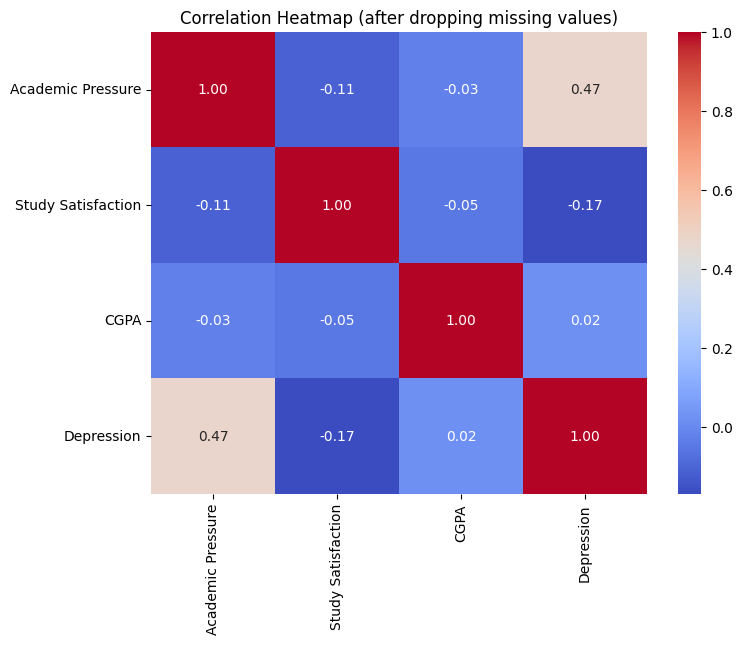

In [5]:
# 필요한 컬럼만 선택하고 결측치 제거
cols = ['Academic Pressure', 'Study Satisfaction', 'CGPA', 'Depression']
subset = train[cols].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (after dropping missing values)")
plt.show()

**학생 관련 변수 상관관계 분석 (`결측치 제거 후`)**

> `Academic Pressure`, `Study Satisfaction`, `CGPA` 세 변수와  
> 타겟 변수 `Depression` 간의 상관관계를 분석한 결과
> 단, **결측치가 있는 행은 모두 제거**한 상태로 계산됨.
<br/>

**중요 전제**  
해당 세 변수의 결측값은 **학생에게만 해당**되는 컬럼으로, 결측이 발생한 부분은 대부분 **직장인 샘플**로 추정됨.  
따라서 이 분석은 **학생 대상 서브셋**을 기반으로 이루어졌고 해석할 수 있다.

<br/>

**히트맵 요약 (상관계수 기준)**
| 변수 | Depression과의 상관관계 | 해석 |
|------|------------------------|------|
| **Academic Pressure** | **+0.47** | 비교적 강한 양의 상관관계 → 학업 스트레스가 클수록 우울 위험 높음 |
| **Study Satisfaction** | **-0.17** | 약한 음의 상관관계 → 학업 만족도가 높을수록 우울 위험 낮음 |
| **CGPA** | **+0.02** | 상관 거의 없음 → 예측 변수로서 정보량 적음 |

<br/>

**결론: 변수 선택 판단**
- `Academic Pressure`, `Study Satisfaction`은 의미 있는 예측 변수로 **유지**
- `CGPA`는 결측률이 높고 상관도 낮아 **제외**

> 학생 관련 변수 중 우울과 가장 관련 있는 요인은 **학업 스트레스**


**파생변수 생성: 결측 여부 표시 변수 (`is_missing_...`)**

일부 변수(`Academic Pressure`, `Study Satisfaction` 등)는 전체 데이터 중 일부 집단(예: 학생)에만 해당되며,  
직장인 샘플에서는 자연스럽게 결측으로 나타나는 특징을 가지고 있다.

이러한 결측은 단순한 누락이 아니라, **의미 있는 그룹 구분 신호**일 가능성이 높다.
따라서, 결측 자체를 하나의 피처로 활용하기 위해 **결측 여부를 나타내는 파생변수**를 생성한다.

- `is_missing_academic_pressure`: `Academic Pressure`가 결측이면 1, 아니면 0  
- `is_missing_study_satisfaction`: `Study Satisfaction`가 결측이면 1, 아니면 0

이러한 변수는 모델이 **"이 값은 원래 존재했는가?"** 를 학습하도록 도와주며,  
단순한 평균 대체(imputation)로 인한 정보 손실을 줄여준다.

In [73]:
# 1. CGPA 컬럼 제거
train.drop(columns=['CGPA'], inplace=True)

# 2. Academic Pressure 결측 여부 파생 변수
train['Academic_Pressure_missing'] = train['Academic Pressure'].isnull().astype(int)

# 3. Study Satisfaction 결측 여부 파생 변수
train['Study_Satisfaction_missing'] = train['Study Satisfaction'].isnull().astype(int)

In [74]:
train['Academic_Pressure_missing']

0         1
1         1
2         0
3         1
4         1
         ..
140695    1
140696    1
140697    1
140698    1
140699    0
Name: Academic_Pressure_missing, Length: 140700, dtype: int64

**결과 예시**

| Academic Pressure | Academic\_Pressure\_missing | Study Satisfaction | Study\_Satisfaction\_missing |
| ----------------- | --------------------------- | ------------------ | ---------------------------- |
| 3.0               | 0                           | 4.0                | 0                            |
| 3.14 (Imputation)              | 1                           | 2.94 (Imputation)           | 1                            |
| 3.14 (Imputation)           | 1                          | 2.94 (Imputation)              | 1                            |

- 원래 컬럼의 NaN은 어떻게 처리?

    - 파생 변수를 만들었기 때문에, 그대로 두어도 됨.
    - 결측 여부 정보를 이미 담고 있어서
    - 하지만 사용하는 모델에 따라 NaN을 허용하지 않으면 대체해야 함

**imputer로 값 채우기**
- 권장되는 방식!

- 파생 변수 없이 값 대체만 하면
    - 결측값이 있었다는 정보를 완전히 잃어버림
    - 실제로 결측이 의미를 가지는 경우 오히려 성능 저하


In [75]:
imputer = SimpleImputer(strategy='mean') # 결측치가 해당 컬럼의 평균 값으로 대체됨.
train['Academic Pressure'] = imputer.fit_transform(train[['Academic Pressure']])
train['Study Satisfaction'] = imputer.fit_transform(train[['Study Satisfaction']])

> 결측 여부를 나타내는 is_missing_컬럼명 추가 + Imputer로 결측값 채우기

이렇게 되면:
1. 결측 여부(정보)는 보존
- 결측이 "학생만 응답 → 직장인은 결측"이라면, 이건 모델이 직업군에 따라 예측 경향을 학습할 수 있게 해줌

2. 모델 훈련에 문제 없음
- Imputer로 채워서 NaN이 사라지므로 모델 학습 가능

3. 모델이 '이 값은 실제가 아니라 채워진 값이다'를 인지할 수 있음
- 예: Study Satisfaction이 3.0인데, is_missing_study_satisfaction = 1이면, 모델은 "이건 채워진 값이구나"라고 인식 가능

#### 1-2. 결측률 26% (Profession)

In [76]:
train['Profession'].fillna('Missing', inplace=True)

/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_3049/4215184188.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Profession'].fillna('Missing', inplace=True)


#### 1-3. 결측률 19% (Academic Pressure, Job Satisfaction)

**중요 전제**

해당 세 변수의 결측값은 직장인에게만 해당되는 컬럼으로, 결측이 발생한 부분은 대부분 학생 샘플로 추정됨.
따라서 이 분석은 직장인 대상 서브셋을 기반으로 이루어졌고 해석할 수 있다.

In [77]:
train['Work_Pressure_missing'] = train['Work Pressure'].isnull().astype(int)
train['Job_Satisfaction_missing'] = train['Job Satisfaction'].isnull().astype(int)

#### 1-4. 나머지 결측치 처리

In [78]:
print(train.isnull().sum().sort_values(ascending=False).head())

Work Pressure       27918
Job Satisfaction    27910
Dietary Habits          4
Financial Stress        4
Degree                  2
dtype: int64


In [79]:
train = train[train['Financial Stress'].notnull()].copy()

In [80]:
print(train.isnull().sum().sort_values(ascending=False).head())

Work Pressure                            27915
Job Satisfaction                         27907
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
dtype: int64


### 2. 범주형 변수 처리

#### 2-1. Sleep Duration

In [81]:
print(train['Sleep Duration'].dtype)

object


In [82]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38783
7-8 hours            36969
More than 8 hours    32725
5-6 hours            32140
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [83]:
# 이상치, 알 수 없는 값들 제거
delete_values = [
    'Indore', 'Pune', 'Moderate', 'Unhealthy', 'Sleep_Duration',
    'Work_Study_Hours', 'No', '45', '49 hours', '55-66 hours', '40-45 hours', 
    '9-5 hours', '10-6 hours', '9-6 hours', '9-5', '45-48 hours', '35-36 hours'
]

train = train[~train['Sleep Duration'].isin(delete_values)].copy()

In [84]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38783
7-8 hours            36969
More than 8 hours    32725
5-6 hours            32140
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
1-6 hours                4
6-8 hours                4
8-9 hours                2
9-11 hours               2
10-11 hours              2
1-3 hours                1
1-2 hours                1
8 hours                  1
than 5 hours             1
3-6 hours                1
Name: count, dtype: int64

**Sleep Duration 문자열 정제 및 수치형 변환**

`Sleep Duration` 변수는 다양한 형식의 문자열(`"5-6 hours"`, `"Less than 5 hours"`, `"More than 8 hours"` 등)로 구성  
- 모델 학습에 사용하기 위해 **명확한 수치형(float)** 으로 변환이 필요

임의로 규칙을 정해서 수면 시간을 정의하였다.

- `"Less than N hours"` → **N - 0.5** 로 변환 (예: `"Less than 5 hours"` → `4.5`)
- `"More than N hours"` → **N + 0.5** 로 변환 (예: `"More than 8 hours"` → `8.5`)
- `"N-M hours"` 혹은 `"N–M hours"` → **(N + M) / 2** 로 변환 (예: `"5-6 hours"` → `5.5`)
- `"N hours"` → **N** 으로 변환
- `"than N hours"` 같은 불완전한 표현 → `"Less than"`과 같은 방식으로 처리
- 기타 알 수 없는 패턴 → **NaN 처리** (이상값으로 간주)

이 과정을 통해 `Sleep Duration`은 모델 학습이 가능한 **연속형 수치 변수**로 변환되며,  
수면 시간과 우울 위험 간의 상관관계를 더 정확히 파악할 수 있게 된다.


In [85]:
def convert_sleep_to_hours(val):
    try:
        val = str(val).strip().lower()

        # 특별 처리: 'than n hours' → 'less than n hours' 간주
        if 'than' in val and 'less' not in val and 'more' not in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) - 0.5

        # Less than n hours → n - 0.5
        if 'less than' in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) - 0.5

        # More than n hours → n + 0.5
        elif 'more than' in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) + 0.5

        # 정확히 n hours → 숫자만 추출
        elif re.match(r'^\d+\s*hours$', val):
            return float(re.findall(r'\d+', val)[0])

        # n-m hours 또는 n–n → 평균값
        elif re.search(r'\d+\s*[-–~]\s*\d+', val):
            nums = [int(n) for n in re.findall(r'\d+', val)]
            if len(nums) == 2:
                return sum(nums) / 2

        # 숫자만 → 그대로
        elif re.match(r'^\d+(\.\d+)?$', val):
            return float(val)

        # 나머지는 이상값으로 간주
        else:
            return np.nan

    except:
        return np.nan


In [86]:
train['Sleep Duration'] = train['Sleep Duration'].apply(convert_sleep_to_hours)

In [87]:
train['Sleep Duration'].value_counts()

Sleep Duration
4.5     38792
7.5     36969
8.5     32727
5.5     32140
3.5        16
6.5         8
5.0         5
2.5         5
7.0         4
10.5        2
10.0        2
1.5         1
2.0         1
8.0         1
Name: count, dtype: int64

In [88]:
print(train['Sleep Duration'].dtype)

float64


#### 2-2. Degree

문제점
- 고유값 115개 → 너무 많음
- 실제 학위 외에 오타, 숫자, 이름 등이 섞여 있음 (29, Vivaan, Advait, Bhavesh, BCA, M.Tech, 등등)

해결 방법
- 빈도 기준 상위 N개만 남기고 나머지는 'Other' 처리

In [89]:
train['Degree'].value_counts()

Degree
Class 12    14727
B.Ed        11690
B.Arch       8741
B.Com        8112
B.Pharm      5856
            ...  
Vivaan          1
MTech           1
29              1
LLCom           1
Advait          1
Name: count, Length: 115, dtype: int64

In [90]:
degree_group_map = {
    # 의학/보건
    'MD': 'Medical',
    'MBBS': 'Medical',
    'B.Pharm': 'Pharmacy',
    'M.Pharm': 'Pharmacy',
    'MPharm': 'Pharmacy',
    'P.Pharm': 'Pharmacy',
    'S.Pharm': 'Pharmacy',
    'N.Pharm': 'Pharmacy',

    # 공학/기술
    'B.Tech': 'Engineering',
    'M.Tech': 'Engineering',
    'ME': 'Engineering',
    'MTech': 'Engineering',
    'M_Tech': 'Engineering',
    'BE': 'Engineering',
    'BCA': 'Engineering',
    'MCA': 'Engineering',
    'E.Tech': 'Engineering',
    'S.Tech': 'Engineering',
    'LLTech': 'Engineering',
    'LLCom': 'Engineering',

    # 인문/사회/비즈니스
    'BBA': 'Business',
    'MBA': 'Business',
    'M. Business Analyst': 'Business',
    'B.Com': 'Commerce',
    'M.Com': 'Commerce',
    'P.Com': 'Commerce',
    'LLB': 'Law',
    'LLM': 'Law',
    'LLBA': 'Law',
    'LL.Com': 'Law',
    'LL B.Ed': 'Education',
    'B.Ed': 'Education',
    'M.Ed': 'Education',
    'L.Ed': 'Education',
    'K.Ed': 'Education',
    'LLEd': 'Education',
    'BEd': 'Education',

    # 과학
    'BSc': 'Science',
    'MSc': 'Science',
    'B.Sc': 'Science',

    # 기타, 건축, 호텔경영 등
    'BHM': 'Hospitality',
    'MHM': 'Hospitality',
    'B.Arch': 'Architecture',
    'M.Arch': 'Architecture',
    'BArch': 'Architecture',
    'B.B.Arch': 'Architecture',

    # 학위 및 학교 졸업
    'PhD': 'PhD',
    'Class 12': 'School',
    'Class 11': 'School',
}

train['degree_group'] =train['Degree'].apply(lambda x: degree_group_map.get(x, 'Other'))

train=train.drop('Degree',axis=1)

In [91]:
train['degree_group'].value_counts()

degree_group
Engineering     26608
Education       17365
School          14728
Commerce        11207
Pharmacy        10397
Science          9906
Law              8996
Business         8849
Architecture     8749
Hospitality      7591
Other            6715
Medical          6460
PhD              3102
Name: count, dtype: int64

#### 2-3. City

문제점
- 도시명 외에 사람 이름 등 잘못된 값이 포함 (Shrey, Vaanya, Ivaan, Gaurav 등)
- 고유값 98개 → 원핫 인코딩 시 고차원 문제 발생

해결 방법
- 상위 K개 도시 유지 + 나머지 Other로 묶기

In [92]:
train['City'].value_counts()

City
Kalyan         6590
Patna          5924
Vasai-Virar    5764
Kolkata        5687
Ahmedabad      5612
               ... 
Shrey             1
Ivaan             1
Vaanya            1
Gaurav            1
Unirar            1
Name: count, Length: 98, dtype: int64

In [93]:
# 상위 15개 도시만 유지
top_cities = train['City'].value_counts().nlargest(15).index
train['City'] = train['City'].where(train['City'].isin(top_cities), other='Other')

In [94]:
train['City'].value_counts()

City
Other            60522
Kalyan            6590
Patna             5924
Vasai-Virar       5764
Kolkata           5687
Ahmedabad         5612
Meerut            5527
Ludhiana          5225
Pune              5210
Rajkot            5207
Visakhapatnam     5175
Srinagar          5073
Mumbai            4965
Indore            4872
Agra              4684
Surat             4636
Name: count, dtype: int64

#### 2-4. Dietary Habits

문제점
- Moderate, Unhealthy, Healthy는 명확한 카테고리
- 나머지는 이상값 / 오입력 / 다른 컬럼에서 잘못 섞인 값임

해결 방법
- 정상 값만 남기고 나머지는 NaN 대체
- 결측값은 최빈값(Moderate)로 대체

In [95]:
train['Dietary Habits'].value_counts()

Dietary Habits
Moderate             49695
Unhealthy            46219
Healthy              44732
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

In [96]:
# 정상 값만 남기고 나머지는 NaN으로
valid_dietary = ['Moderate', 'Unhealthy', 'Healthy']
train['Dietary Habits'] = train['Dietary Habits'].where(train['Dietary Habits'].isin(valid_dietary))

# 결측값은 최빈값으로 대체
train['Dietary Habits'] = train['Dietary Habits'].fillna(train['Dietary Habits'].mode()[0])

In [97]:
train['Dietary Habits'].value_counts()

Dietary Habits
Moderate     49722
Unhealthy    46219
Healthy      44732
Name: count, dtype: int64

#### 2-5. 이진 범주 변환 

모델 학습을 위해 `Yes/No`, `Male/Female`, `Student/Working Professional` 등 이진 문자열로 구성된 변수들을  
`0`과 `1`로 **이진 인코딩(Binary Encoding)** 하였음.

**처리된 변수 및 매핑 기준**

- `Have you ever had suicidal thoughts ?`  
  → `'Yes'` → `1`, `'No'` → `0`

- `Family History of Mental Illness`  
  → `'Yes'` → `1`, `'No'` → `0`

- `Gender`  
  → `'Male'` → `1`, `'Female'` → `0`

- `Working Professional or Student`  
  → `'Working Professional'` → `1`, `'Student'` → `0`

이러한 변환을 통해 문자열 변수들이 **수치형 피처로 정제**되며,  
모델이 해당 변수들을 직접 학습에 활용 가능

In [98]:
binary_cols = ['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for col in binary_cols:
    train[col] = train[col].map({'Yes': 1, 'No': 0})

In [99]:
train['Gender'] = train['Gender'].map({'Male': 1, 'Female': 0})
train['Working Professional or Student'] = train['Working Professional or Student'].map({'Working Professional': 1, 'Student': 0})

### 3. 수치형 변수 처리

In [100]:
train.describe()

,Gender,Age,Working Professional or Student,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Academic_Pressure_missing,Study_Satisfaction_missing,Work_Pressure_missing,Job_Satisfaction_missing
count,140673.000000,140673.000000,140673.000000,140673.000000,112762.000000,140673.000000,112770.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000
mean,0.550582,40.388376,0.801710,3.142280,2.999033,2.944923,2.974532,6.447627,0.494395,6.252543,2.988967,0.497096,0.181726,0.801739,0.801739,0.198410,0.198354
std,0.497437,12.384379,0.398713,0.614668,1.405814,0.605609,1.416102,1.588896,0.499970,3.853676,1.413628,0.499993,0.385620,0.398691,0.398691,0.398804,0.398761
min,0.000000,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,1.000000,3.142273,2.000000,2.944940,2.000000,4.500000,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,42.000000,1.000000,3.142273,3.000000,2.944940,3.000000,5.500000,0.000000,6.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,51.000000,1.000000,3.142273,4.000000,2.944940,4.000000,7.500000,1.000000,10.000000,4.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,60.000000,1.000000,5.000000,5.000000,5.000000,5.000000,10.500000,1.000000,12.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**수치형 변수 스케일링 대상 정리**

값의 범위가 크거나 단위가 다른 변수와 달라서 **스케일 차이로 인한 영향**을 줄이기 위해 표준화(Standardization)가 필요하다.

| 컬럼명                | 범위           | 평균 ± 표준편차           | 이유                                                   |
| ------------------ | ------------ | ------------------------ | ------------------------------------------------------ |
| `Age`              | 18 ~ 60      | 평균 40.4, std 12.4       | 넓은 연령 분포로 인해 모델 학습 시 영향도가 커질 수 있음                  |
| `Work/Study Hours` | 0 ~ 12       | 평균 6.25, std 3.85       | 0부터 12까지의 넓은 범위 → 다른 변수들과 균형 맞추기 위해 필요          |
| `Financial Stress` | 1 ~ 5        | 평균 2.99, std 1.41       | 스트레스 계열 변수들과 단위를 통일하여 모델 해석력 및 학습 안정성 확보         |
| `Sleep Duration`   | 1.5 ~ 10.5   | 평균 6.45, std 1.59       | 수면 시간 역시 개별 분포가 커서 다른 변수 대비 영향도 차이 발생 가능성 있음     |

- 표준화를 사용하여 전처리 스케일링을 적용하였다.

In [101]:
from sklearn.preprocessing import StandardScaler
scale_cols = ['Age', 'Sleep Duration', 'Work/Study Hours', 'Financial Stress']

scaler = StandardScaler()
train[scale_cols] = scaler.fit_transform(train[scale_cols])

### 4. 원-핫 인코딩 + 타겟 인코딩

**범주형 변수 인코딩 전략**

- 모델 학습을 위해 범주형 변수들을 수치형으로 변환해야 함
- **두 가지 인코딩 방식**을 상황에 맞게 혼합하여 적용
- 
범주 수가 적은 경우: One-Hot Encoding 추천

범주 수가 많은 경우: Target Encoding

In [102]:
# 범주형 변수의 고유값 수
train.select_dtypes(include='object').nunique()

City              16
Profession        65
Dietary Habits     3
degree_group      13
dtype: int64

| 컬럼명              | 고유값 수 | 추천 인코딩 방식                                       | 이유                                                                                  |
| ---------------- | ----- | ----------------------------------------------- | ----------------------------------------------------------------------------------- |
| `City`           | 16개   | **Target Encoding** |범주 수가 다소 많음. One-Hot Encoding은 차원을 불필요하게 늘릴 수 있음. 대신 타겟값(Depression)과의 관계를 반영할 수 있음 |
| `Profession`     | 65개   | **Target Encoding**                          | 매우 많은 범주 수 → One-Hot Encoding은 비효율적. 타겟과의 상관성을 학습에 반영하는 Target Encoding이 적합         |
| `Dietary Habits` | 3개    | **One-Hot Encoding**                          | 범주 수 적고, 의미 명확. 각 항목 독립적으로 표현하는 게 모델 해석에 유리                                         |
| `degree_group`   | 13개   | **One-Hot Encoding**        | 경계선에 있는 수  |


- 고유값이 10개 미만이면 → One-Hot Encoding
- 10개 이상이면 → Target Encoding
- Target Encoding은 타겟(Depression) 과의 관계가 있을 때 특히 강력함
    - 단, Target Encoding은 과적합을 막기 위해 K-fold 방식으로 처리하면 더 안전함

In [103]:
# Degree, Dietary Habits - One-hot encoding
train = pd.get_dummies(train, columns=['degree_group', 'Dietary Habits'], drop_first=True)

# Profession, City - Target encoding 
# 각 범주가 가진 Depression 평균값으로 치환
# 우울증 비율을 수치를 반영함으로써 의미 있는 신호를 학습할 수 있도록 함.
for col in ['Profession', 'City']:
    target_mean = train.groupby(col)['Depression'].mean()
    train[col + '_target'] = train[col].map(target_mean)

# 이후 필요시 원본 컬럼 제거
train.drop(columns=['Profession', 'City'], inplace=True)

In [104]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    train_copy = train

    y_target = train_copy['Depression']
    X_features = train_copy.drop('Depression', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(train)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(
    n_estimators=100,       # 트리 개수 (적당함)
    max_depth=4,            # 과적합 방지용 적당한 깊이
    learning_rate=0.1,      # 기본 학습률
    subsample=0.8,          # 전체 샘플 중 일부만 사용 → 일반화 성능↑
    colsample_bytree=0.8,   # 피처 중 일부만 사용 → 과적합 방지
    use_label_encoder=False,
    eval_metric='logloss',  # 분류 문제의 표준 평가지표
    random_state=42,
    n_jobs=-1               # 병렬 처리
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

/Users/choieunseo/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [02:35:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9387
